### Necessary Imports

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.autograd import Variable
import torch.nn.functional as F
import os
import csv

torch.set_default_dtype(torch.float64)

### Create a identifier and directories for the same

Define the identifier i.e. the direcctory will be used for writing all the temporary files like Buckets data and writing the model files. The path can be changed in the below cell. 

In [32]:
identifier = "maps"

if not os.path.exists("models/{}".format(identifier)):
    os.makedirs("models/{}".format(identifier))
        
if not os.path.exists("/media/yash/Data/CSE662_Data/Buckets/{}".format(identifier)):
    os.makedirs("/media/yash/Data/CSE662_Data/Buckets/{}".format(identifier))

### Set up the data path and preprocess steps. 

The preprocess would involve subtracting the offset and then scaling the data between 0 and 1. 

### Weblogs Data

In [3]:
offset = 1425168000107.1
x_max = 2678399597
y_max = 75689906
total_rows = 74166063
path = "/media/yash/Data/CSE662_Data/"  # Dataset
dataset_name = "WebLogs/"

### Maps Data

In [33]:
offset = -180
x_max = 360
y_max = 199999999
total_rows = 174905625
path = "/media/yash/Data/CSE662_Data/"  # Dataset
dataset_name = "Maps/"

### LogNormal Data

In [29]:
offset = 6025
x_max = 540958858
y_max = 189999999
total_rows = 190000000
path = "/media/yash/Data/CSE662_Data/"  # Dataset
dataset_name = "LogNormal/"

### Define Model Architecture

In [ ]:
class SuperNet(torch.nn.Module):
    def __init__(self, n1=16, n2=16, bias=True):
        super(SuperNet, self).__init__()
        if n2 == 0:
            self.layers = torch.nn.Linear(in_features=1, out_features=n1, bias=bias)
        else:
            self.layers = torch.nn.Sequential(torch.nn.Linear(in_features=1, out_features=n1, bias=bias),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(n1, n2, bias=bias),
                                        )

        self.out_layer = torch.nn.Linear(n1 if n2 == 0 else n2, 1, bias=bias)

    def forward(self, x):
        out = F.relu(self.layers(x))
        return self.out_layer(out)

### Create model object and initialize optimizer

In [ ]:
model = SuperNet(16,16,True)

if torch.cuda.is_available():
    model.cuda()
    
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

### Saving the state dict for Optimizer

In [ ]:
torch.save(obj=optimizer.state_dict(), f="models/{}/super_layer_optim.pt".format(identifier))

### Getting the state dict for Optimizer

In [ ]:
optimizer.load_state_dict(torch.load(f="models/{}/super_layer_optim.pt".format(identifier)))

### Getting the state dict for Optimizer

In [ ]:
model.load_state_dict(torch.load(f="models/{}/super_layer.pt".format(identifier)))

### Saving the state dict for Model

In [ ]:
torch.save(obj=model.state_dict(), f="models/{}/super_layer.pt".format(identifier))

### Training the model on sample of data (Uniform Sampling) 

This step can be avoided. But this helps reach the optimum value faster. The data can be sampled using the cell provided in the end by providing the percentage. 

Iteratively increase the data samples and then move onto the below on disk training process.

In [ ]:
filename = path + dataset_name + "sorted_keys_non_repeated_sampled_1000.csv"

x = pd.read_csv(filename, header = None, sep=' ', dtype=np.float64, index_col = False)
x = x.values

x_train = x[:,1]-offset
x_train = x_train.reshape((-1,1))
x_train = x_train/x_max

y_train = x[:,0]
y_train = y_train.reshape((-1,1))
y_train = y_train/y_max

print("Data Dimensions: ", x.shape)

In [ ]:
last_loss = 100000

for epoch in range(1000000):
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1 == 0:
        if last_loss <= loss.item():
            print("Updating learning rate")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.8
        last_loss = loss.item()
        print('epoch {}, loss {}'.format(epoch+1, loss.item()))

### Update the current learning rate

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.4

### Print the current the learning rate

In [ ]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

### Training it on complete data finally 

In [ ]:
filename = path + dataset_name + "shuffled_keys_non_repeated.csv"

epochs = 25
chunk_size = 16777216
batch_size = 1024

In [ ]:
last_loss = 1000000000

for epoch in range(epochs):
    epoch_loss = 0
    index = 0
    for index in range(total_rows // chunk_size + 1):
        x = next(pd.read_csv(filename, skiprows=index * chunk_size, chunksize=chunk_size,
                        header = None, sep=' ', dtype=np.float64, index_col = False))
        x = x.values
        x_train = x[:,1]-offset
        x_train = x_train.reshape((-1,1))
        x_train = x_train/x_max

        y_train = x[:,0]
        y_train = y_train.reshape((-1,1))
        y_train = y_train/y_max
        
        for small_batch in range(0,x_train.shape[0],batch_size):
            
            if torch.cuda.is_available():
                inputs = Variable(torch.from_numpy(x_train[small_batch:min(small_batch+batch_size,x_train.shape[0]),:]).cuda())
                labels = Variable(torch.from_numpy(y_train[small_batch:min(small_batch+batch_size,x_train.shape[0]),:]).cuda())
            else:
                inputs = Variable(torch.from_numpy(x_train[small_batch:min(small_batch+batch_size,x_train.shape[0]),:]))
                labels = Variable(torch.from_numpy(y_train[small_batch:min(small_batch+batch_size,x_train.shape[0]),:]))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
            if (small_batch) % 6400000 == 0:
                print('Batch {}, loss {}'.format(small_batch, loss.item()))        
        
        
    if (epoch+1) % 1 == 0:
        if last_loss <= epoch_loss:
            print("Updating learning rate")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.8
        last_loss = epoch_loss
    print('epoch {}, loss {}'.format(epoch+1, epoch_loss))

### Dividing the data into multiple buckets

In [ ]:
filename = path + dataset_name + "sorted_keys_non_repeated.csv"

chunk_size = 16777216
batch_size = 1024
all_total_buckets = [10000, 20000, 50000, 100000, 200000]

In [ ]:
big_bucket = dict()

for total_buckets in all_total_buckets:
    if not os.path.exists("/media/yash/Data/CSE662_Data/Buckets/{}/{}".format(identifier, total_buckets)):
        os.makedirs("/media/yash/Data/CSE662_Data/Buckets/{}/{}".format(identifier, total_buckets))

    for i in range(total_buckets):
        big_bucket[i] = []

    count = 0
    for index in range(total_rows // chunk_size + 1):
        x = next(pd.read_csv(filename, skiprows=index * chunk_size, chunksize=chunk_size,
                        header = None, sep=' ', dtype=np.float64, index_col = False))
        x = x.values
        x_train = x[:,1]-offset
        x_train = x_train.reshape((-1,1))
        x_train = x_train/x_max
    
        y_train = x[:,0]
        y_train = y_train.reshape((-1,1))
        y_train = y_train/y_max

        with torch.no_grad(): # we don't need gradients in the testing phase
            if torch.cuda.is_available():
                predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
            else:
                predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()

        for k, v, o in zip(x_train, y_train, predicted):
            k = k.item()
            v = v.item()
            o = o.item()

            mn = (total_buckets * o)
            model_num = np.clip(np.floor(mn), 0, total_buckets - 1)
            count += 1
            big_bucket[model_num].append([v, o])

        print("\nFlushing data to disk.\n")
        for b in big_bucket:
            f=open("/media/yash/Data/CSE662_Data/Buckets/{}/{}/bucket_{}.csv".format(identifier, total_buckets, b),'a')
            writer = csv.writer(f, delimiter=' ')
            for row in big_bucket[b]:
                writer.writerow(row)
            f.close()
        print("Data processed: ", count)
        big_bucket.clear()

        for i in range(total_buckets):
            big_bucket[i] = []

### Point wise error for model 1 

This has been used during visualizations. The calculations were written onto a file and then the graphs were visualized using histograms to infer how much the searcch space is reduced. 

In [ ]:
filename = path + dataset_name + "sorted_keys_non_repeated.csv"

chunk_size = 16777216
batch_size = 1024

error_array = []

if not os.path.exists("/media/yash/Data/CSE662_Data/Layer_1_Output/{}".format(identifier)):
    os.makedirs("/media/yash/Data/CSE662_Data/Layer_1_Output/{}".format(identifier))

f=open("/media/yash/Data/CSE662_Data/Layer_1_Output/{}/layer_1_op.csv".format(identifier),'a')
writer = csv.writer(f, delimiter=' ')

count = 0
for index in range(total_rows // chunk_size + 1):
    x = next(pd.read_csv(filename, skiprows=index * chunk_size, chunksize=chunk_size,
                    header = None, sep=' ', dtype=np.float64, index_col = False))
    x = x.values
    x_train = x[:,1]-offset
    x_train = x_train.reshape((-1,1))
    x_train = x_train/x_max

    y_train = x[:,0]
    y_train = y_train.reshape((-1,1))
    y_train = y_train/y_max

    with torch.no_grad(): # we don't need gradients in the testing phase
        if torch.cuda.is_available():
            predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
        else:
            predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()

    for k, v, o in zip(x_train, y_train, predicted):
        k = k.item()
        v = v.item()
        o = o.item()
        
        k = k*x_max
        v = v*y_max
        o = o*y_max
        
        e = o - v
        count += 1
        error_array.append([v, k, o, e])

    print("\nFlushing data to disk.\n")
    
    for row in error_array:
        writer.writerow(row)
    
    print("Data processed: ", count)
    error_array.clear()
f.close()

### Visualize the sample of data and model output on the same data. 

Uses the same data i.e. uploaded in memory for sample training. 

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()

plt.clf()
plt.plot(x_train, y_train, '--', label='Data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.savefig("/home/yash/Desktop/CSE-662/Code/LIS/graphs/{}_layer_1.png".format(identifier))
plt.show()

### Use the following code to unifromly sample data. 

In [ ]:
sample_rate = 10

fr = path + dataset_name + "sorted_keys_non_repeated.csv"
fw = path + dataset_name + "sorted_keys_non_repeated_sampled_{}.csv".format(sample_rate)

inF = open(fr, "r")
outF = open(fw, "w")
i = 0
for line in inF:
    if i%sample_rate == 0:
        outF.write(line)
    i+=1
outF.close()
inF.close()

### Stage 2 models for Linear Regression

In [ ]:
import datetime
from sklearn.linear_model import LinearRegression

def save_scikit(identifier, total_buckets, x_max, y_max, total_rows, threshold):
    results = []
    threshs = []
    data_details = [total_buckets, x_max, y_max, total_rows, 0]
    
    for i in range(total_buckets):
        result, thresh = scikit_linreg(identifier=identifier, bucket=i, threshold=threshold, 
                                     y_max = y_max, total_buckets = total_buckets)
        results.append(result)
        threshs.append(thresh)
    
    for i in range(len(threshold)): 
        f=open("models/{}/model_params_layer_2_{}_{}.txt".format(identifier, total_buckets, threshold[i]),'a')
        writer = csv.writer(f, delimiter=' ')
        data_details[4] = threshold[i]
        writer.writerow(data_details)
        
        for j in range(len(results)):
            results[j][7] = threshs[j][i]
            writer.writerow(results[j])
        f.close()
    
def scikit_linreg(identifier, bucket, threshold, y_max, total_buckets):
    regressor = LinearRegression(n_jobs=-1)
    data = np.transpose(np.loadtxt("/media/yash/Data/CSE662_Data/Buckets/{}/{}/bucket_{}.csv".format(identifier, total_buckets, bucket), delimiter=' ', dtype = np.float64))
    thresh = []
    if data.shape[0] == 0:
        sol = [-1, -1, -1, -1, -1, -1, -1, 0]
        for t in threshold:
            thresh.append(-1)
        return sol, thresh
    
    regressor.fit(data[1].reshape(-1, 1), data[0].reshape(-1, 1))
    op = regressor.predict(data[1].reshape(-1, 1))
    difference = np.subtract(np.transpose(data[0]).reshape(-1, 1), op)
    min_error = np.min(difference)*y_max
    max_error = np.max(difference)*y_max
    
    sol = [regressor.coef_[0][0], regressor.intercept_[0], min_error, max_error, np.min(data[0])*y_max, 
           np.max(data[0])*y_max, np.max(data[0])*y_max - np.min(data[0])*y_max, 0]
    
    for t in threshold:
        if max_error > t or  0-min_error > t:
            thresh.append(0)
        else: thresh.append(1)
        
    return sol, thresh

In [ ]:
threshold_size = [32,64,128,256]
buckets_size = [10000, 20000, 50000, 100000, 200000]

for b in buckets_size:
    print("Bucket count: ", b)
    start = datetime.datetime.now()
    save_scikit(identifier, b, x_max, y_max, total_rows, threshold=threshold_size)
    end = datetime.datetime.now()
    print("\nTime taken: " + str(end - start))

### Visualize buckets 

Individual bucket data and the model can be visualized for further analytics. 

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
%matplotlib inline

def analyze_bucket(identifier, buckets_count, b, degree):
    data = np.transpose(np.loadtxt("/media/yash/Data/CSE662_Data/Buckets/{}/{}/bucket_{}.csv".format(identifier, buckets_count, b), delimiter=' ', dtype = np.float64))
    
    print("Bucket Number:", b)
    
    if data.shape[0] == 0: 
        print("The bucket is empty.")
        return
    X = data[1].reshape(-1, 1)*x_max
    y = data[0].reshape(-1, 1)*y_max
    
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    lg = LinearRegression()
    lg.fit(X_, y)

    op = lg.predict(X_)
    
    difference = np.subtract(y, op)
    min_error = np.min(difference)
    max_error = np.max(difference)

    plt.clf()
    plt.scatter(X, y,color='g')
    plt.plot(X, op,color='k')
    plt.xlabel('Bucket Size: {}\nCoefficient: {}  ,Intercept: {}\nMin Error: {} ,Max Error: {}\nBucket Range: {} to {}'.format(X_.shape, lg.coef_[0],lg.intercept_[0], min_error, max_error, np.min(y), np.max(y)))
    plt.tight_layout()
    plt.savefig("/home/yash/Desktop/CSE-662/Code/LIS/graphs/{}_{}.png".format(identifier, b))

Bucket Number: 0
Bucket Number: 12500
Bucket Number: 25000
Bucket Number: 37500
Bucket Number: 50000
Bucket Number: 62500
Bucket Number: 75000
Bucket Number: 87500
Bucket Number: 99900
The bucket is empty.


/home/yash/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: loadtxt: Empty input file: "/media/yash/Data/CSE662_Data/Buckets/maps/100000/bucket_99900.csv"
  if __name__ == '__main__':


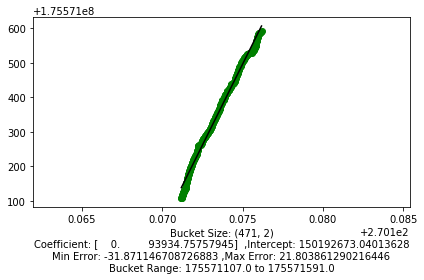

In [35]:
buckets = [0, 125, 250, 375, 500, 625, 750, 875, 999]
b_mult = 100

for b in buckets:
    analyze_bucket(identifier = identifier, buckets_count = 1000 * b_mult, b = b*b_mult, degree = 1)

### Write layer 1 weights to file

In [ ]:
def write_weights():
    file = torch.load(f="models/{}/super_layer.pt".format(identifier))
    open("models/{}/model_params_layer_1.txt".format(identifier), 'w').close()
    f = open("models/{}/model_params_layer_1.txt".format(identifier), "w+")
    
    print("Writing weights for layers: ")
    for k, v in file.items():
        print(k)
        if(k == "layers.0.bias" or k == "layers.2.bias" or k == "out_layer.bias" or k == "layers.0.weight"):
            for val in v:
                f.write(str(val.item()) + " ")
            f.write("\n")
        elif(k == "layers.2.weight"):
            for val in v:
                for val_2 in val:
                    f.write(str(val_2.item()) + " ")
                f.write("\n")
        else:
            for val in v[0]:
                f.write(str(val.item()) + " ")
            f.write("\n")

In [ ]:
write_weights()

### Test particluar key's layer wise output

In [ ]:
class SuperNetTest(torch.nn.Module):
    def __init__(self, n1=16, n2=16, bias=True):
        super(SuperNetTest, self).__init__()

        if n2 == 0:
            self.layers = torch.nn.Linear(in_features=1, out_features=n1, bias=bias)
            self.layers.register_forward_hook(printer)
        else:
            self.layers = torch.nn.Sequential(torch.nn.Linear(in_features=1, out_features=n1, bias=bias),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(n1, n2, bias=bias),
                                        )
            for layer in self.layers:
                layer.register_forward_hook(printer)
        
        self.out_layer = torch.nn.Linear(n1 if n2 == 0 else n2, 1, bias=bias)

    def forward(self, x):
        out = F.relu(self.layers(x))
        return self.out_layer(out)
    
def printer(self, ip, op):
    print("Layer Name:", self.__class__.__name__)
    print("Layer Parameters: ")
    for o in op:
        print(str(o.item()))

def test_key(key, total_buckets, n1, n2, bias):
    key = key - offset 
    key = key / x_max
    print("Updated Model Input: ", key)
    super_model = SuperNetTest(n1=n1, n2=n2, bias= bias)
    super_model.load_state_dict(torch.load(f="models/{}/super_layer.pt".format(identifier)))
    super_model.eval()

    key = torch.tensor([key])
    output = super_model(key)

    for k, o in zip(key, output):
        k = k.item()
        o = o.item()

    print("Model Output: ", o)
    mn = (total_buckets * o)
    print("After Multiplication: ", mn)    
    model_num = np.clip(np.floor(mn), 0, total_buckets - 1)    
    print("Model Index: ", model_num)

In [ ]:
test_key(540437109, 100000, 16, 16, True)